In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import shap
from graphviz import Source

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import scipy
from scipy.stats import pearsonr, spearmanr
import scipy.cluster.hierarchy as sch

from tqdm import tqdm

# Functions

## Data processing functions

In [2]:
def import_data():
    # Import data
    col_names = pd.read_csv("communities_names.csv", header = None)
    list_of_column_names = []

    for index, row_data in col_names.iterrows():
        list_of_column_names.append(str(row_data[0]))

    data = pd.read_csv("communities_data.csv", names = list_of_column_names)

    # Remove categorical columns 
    # 1: county and communities have many missing values
    # 2: communityname would be a direct indicator of crime and should be removed
    # 3: state is not that important
    data.drop(labels = ["state", "county", "community", "communityname"],axis = 1, inplace = True)

    # We also remove the fold-column since this is only present for reproducing article findings
    data.drop(labels = ["fold"],axis = 1, inplace = True)

    # Drop columns with missing data
    col_names_missing_vals = pd.read_csv("communities_names_missing.csv", header = None)
    list_of_column_names_missing_vals = []

    for index, row_data in col_names_missing_vals.iterrows():
        list_of_column_names_missing_vals.append(str(row_data[0]))

    data.drop(labels = list_of_column_names_missing_vals,axis = 1, inplace = True)    
    
    # Make data_init
    data_init = data.copy()
    
    # Make a categorical column for blackness where we set a threshold (just for visualization purposes)
    racepctblack = np.asarray(data.racepctblack)
    threshold = 0.15 # Previously 0.4
    IsBlack = [1 if x>threshold else 0 for x in racepctblack]
    data["IsBlack"] = IsBlack

    # Make a categorical column for crime
    crime_rate = np.asarray(data.ViolentCrimesPerPop)
    threshold_crime = np.quantile(data_init.ViolentCrimesPerPop, 0.70)
    HighCrime = [1 if x>threshold_crime else 0 for x in crime_rate]
    data["HighCrime"] = HighCrime
    
    # Make a full dataframe where we have not removed the protected columns or the label
    data_full = data.copy()
    
    # Remove protected features and put into separate dataframe
    # Note: this includes all racepct-columns (black, white, asian, hipspanic), since one can be somewhat derived from the others
    protected_cols = ["IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
    data_protected = pd.concat([data.pop(x) for x in protected_cols], axis=1)
    
    # Remove y column (the label)
    y_cols = ["ViolentCrimesPerPop", "HighCrime"]
    data_y = pd.concat([data.pop(x) for x in y_cols], axis=1)
    
    return data_init, data_full, data, data_protected, data_y


In [3]:
def autolabel(rects, axis, fontsize):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize = fontsize)

In [4]:
def scaling_func(scaling_obj):
    def scale(x_train, x_test):
        scaler = scaling_obj().fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test)
    return scale

In [5]:
def reproject_features(data, protected_cols, nonprotected_cols):
    """
    generate a fair representation of nonprotected columns which are independent from any columns in protected_cols
    data: a data frame
    protected_cols: list of strings, the protected columns
    nonprotected_col: string, all other data columns 

    NOTE: this function assumes the data is already centered 
    """
    # make a copy of data
    df = data.copy()
    # Protected features
    protect = df[protected_cols].values
    # extract data about nonprotected columns
    debiased_nonprotect = df[nonprotected_cols].values
    # crease an orthonormal basis
    base_protect = scipy.linalg.orth(protect)
    for j in range(debiased_nonprotect.shape[1]):
        debiased_nonprotect[:,
                            j] -= base_protect @ base_protect.T @ debiased_nonprotect[:, j]
    return debiased_nonprotect


def reproject_features_w_regul(data, protected_cols, nonprotected_cols, lambda_):
    """
    generate a fair representation of nonprotected columns which are independent from any columns in protected_cols
    dat_: a data frame
    protected_cols: list of strings, the protected columns
    nonprotected_col: string, all other data columns 
    lambda_: float number between 0 and 1, 0 means totally fair; 1 means same as raw data
    """

    # run the normal reproject_features function
    r = reproject_features(data, protected_cols, nonprotected_cols)

    # extract data about nonprotected variables
    nonprotect = data[nonprotected_cols].values
    # standardize columns

    return r + lambda_*(nonprotect - r)


def debias_data(protected_cols, nonprotected_cols, lambda_=0):
    """
    Debias data, data pipeline

    Arguments
    ---------
    protected_cols: list of strings, 
        the protected columns

    nonprotected_col: String, 
        all other data columns 

    Returns
    -------
    Function(X_train, X_test) => X_train_r, X_test_r
        A fucntion which takes X_train, X_test and returns the reprojected versions of X_train, X_test

    """
    def call(X_train, X_test):
        # Standard scale the data data
        _mean = np.mean(X_train, axis=0)
        _std = np.std(X_train, ddof=1, axis=0)
        X_train_scaled = (X_train - _mean)/_std
        X_test_scaled = (X_test - _mean)/_std
        # reproject features
        X_train_r = reproject_features_w_regul(
            X_train_scaled, protected_cols, nonprotected_cols, lambda_)
        X_test_r = reproject_features_w_regul(
            X_test_scaled, protected_cols, nonprotected_cols, lambda_)
        return X_train_r, X_test_r
    return call

## Model evaluation functions

In [6]:
def test_model(model, X, y, kfold, scaler=None, model_params={}):
    """
    Test models using some cross validation method and with a scaling method.

    Parameters
    ----------
    model : sklearn model object. 
        This object must not be instansiated

    X : pandas.Dataframe
        df containing all the features, which the model should be trained on

    y : np.array
        An array on the taget values

    kfold : sklearn.model_selection method e.g. KFold
        This object must be initialised. See example

    scaler : Function, default=None
        Data processing pipeline of the form 
        (X_train, X_test) => X_train_processed, X_test_processed
        If None, then are the data not processed

    model_params : Dict, default=Dict
        A dictionary containing model parameters

    Returns
    -------
    numpy.array
        An array containing the predictions

    Example
    -------
    X, y = df.drop(columns=['credit_risk']), df['credit_risk'].values
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    process_data = scale_data()
    model = LogisticRegression
    preds = test_model(model, X, y, kfold, process_data)
    """
    preds = np.zeros(len(y))

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = np.array(y)[train_index]
        if scaler:
            X_train, X_test = scaler(X_train, X_test)

        tmp_model = model(**model_params)
        tmp_model = tmp_model.fit(X_train, y_train)
        preds[test_index] = tmp_model.predict(X_test)
    return preds

In [7]:
def calc_recall(tp, fn):
    """
    True positive rate (TPR, also called sensitivity) 
    """
    return tp/(tp+fn)


def calc_fpr(tn, fp):
    """
    False positive rate (also known as fall-out or false alarm ratio) 
    """
    return fp/(tn+fp)


def equalized_odds(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = calc_recall(tp, fn)
    fpr = calc_fpr(tn, fp)
    return recall, fpr

## Visualization functions

In [8]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [9]:
# Helping function to cluster correlations from https://wil.yegelwel.com/cluster-correlation-matrix/
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


def spearmanr_pval(x, y):
    return spearmanr(x, y)[1]


def pearsonr_pval(x, y):
    return pearsonr(x, y)[1]


def get_significant_correlations(df, method="pearson", p_val=0.05, cluster=True):
    corr = df.corr(method=method)
    # Bonferroni correction
    corrected_p_val = p_val / (len(df.columns)**2/2)

    if method == "spearman":
        corr_pvals = df.corr(spearmanr_pval)
    elif method == "pearson":
        corr_pvals = df.corr(pearsonr_pval)

    # Set significant values to 1
    significant_matrix = np.ones(corr.shape)
    significant_matrix[corr_pvals >= corrected_p_val] = 0
    # Set un-significant correlations to 0
    corr = corr * significant_matrix

    # Return clusrtered corr
    if cluster:
        return cluster_corr(corr)
    else:
        return corr

# Load data

In [10]:
data_init, data_full, data, data_protected, data_y = import_data()

Descriptions:

- **df_init** Has all columns where there is no missing data and which are not continuous. Does not have the user defined threhold-columns (IsBlack and HighCrime)
- **df_all** Has all columns where there is no missing data and which are not continuous, including IsBlack and HighCrime which are defined using threholds
- **df** Has all columns with no missing data and which are not continuous and which are neither protected or the target value
- **df_protected** Has protected columns: "IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"
- **df_y** Has y-column (both continuous and threhold): "ViolentCrimesPerPop", "HighCrime"

# EDA

In [11]:
data_full.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop,IsBlack,HighCrime
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,0.336264,0.423164,...,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052,0.237979,0.316449,0.292377
std,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,0.166505,0.179185,...,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328,0.232985,0.465207,0.454969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,0.250000,0.300000,...,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000,0.070000,0.000000,0.000000
50%,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,0.290000,0.420000,...,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000,0.150000,0.000000,0.000000
75%,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,0.360000,0.530000,...,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000,0.330000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Imbalance in terms of high/low crime




In [12]:
rows_high_crime = len(data_full[data_full.HighCrime == 1].index)
rows_low_crime = len(data_full[data_full.HighCrime == 0].index)

print(f"Number of rows with high crime is {rows_high_crime}, corresponding to {np.round(100 * rows_high_crime/len(data_full),2)} % of the data")
print(f"Number of rows with low crime is {rows_low_crime}, corresponding to {np.round(100 * rows_low_crime/len(data_full),2)} % of the data")

print(f"Imbalance ratio (IR) is {np.round(rows_low_crime/rows_high_crime,2)}")

Number of rows with high crime is 583, corresponding to 29.24 % of the data
Number of rows with low crime is 1411, corresponding to 70.76 % of the data
Imbalance ratio (IR) is 2.42


#### Representations bias: neighbourhoods with a majority of white people are greatly overrepresented

https://www.census.gov/quickfacts/fact/table/US/PST045221

Note: the columns racepctblack, white, asian and hipspanic does not add to one, since individuals can fit into one or more categories. 

According to the census data, at least 13.4 percent of the population is black (up to 2.8 percent more if we take all the people in the 'two or more races' category into consideration as well). So we actually have a slight overrepresentation in the data if we compare with the demographics. However, if we just look at the data as is, then we can see that white people are overrepresented and by consequence, we know much more about predominantly white neighbourhoods. 

In other words: population bias leads to skewed data.

In [13]:
non_black_count = len(data_full[data_full.IsBlack == 0].index)
black_count = len(data_full[data_full.IsBlack == 1].index)

print(f"Number of neighbourhoods categorized as white: {non_black_count}, corresponding to {np.round(100 * non_black_count/len(data_full),2)} % of the data")
print(f"Number of neighbourhoods categorized as black: {black_count}, corresponding to {np.round(100 * black_count/len(data_full),2)} % of the data")

print(f"Imbalance ratio (IR) is {np.round(non_black_count/black_count,2)}")

Number of neighbourhoods categorized as white: 1363, corresponding to 68.36 % of the data
Number of neighbourhoods categorized as black: 631, corresponding to 31.64 % of the data
Imbalance ratio (IR) is 2.16


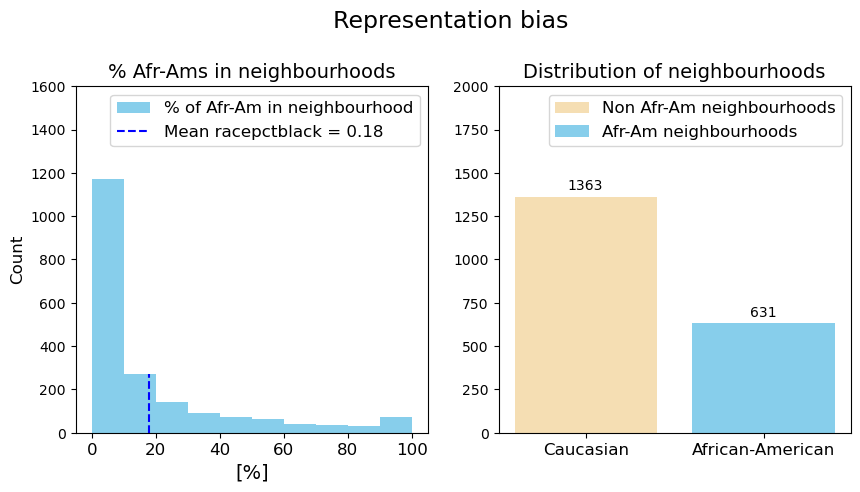

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4.5), sharey = False)
fig.suptitle('Representation bias', fontsize = 17, y = 1.05)

ax1.hist(data_full.racepctblack, color = 'skyblue', label = "% of Afr-Am in neighbourhood")
ax1.axvline(data_full.racepctblack.values.mean(), ymax = 0.17, color = "blue", linestyle = "--", label = f"Mean racepctblack = {np.round(data_full.racepctblack.values.mean(),2)}")
ax1.set_title("% Afr-Ams in neighbourhoods", fontsize = 14)
ax1.legend(fontsize = 12)
ax1.set_ylabel("Count", fontsize = 12)
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([0, 20, 40, 60, 80, 100], fontsize = 12)
ax1.set_xlabel("[%]", fontsize = 14)
ax1.set_ylim(top = 1600)

rect1 = ax2.bar(0, non_black_count, label='Non Afr-Am neighbourhoods', color = 'wheat')
rect2 = ax2.bar(1, black_count, label='Afr-Am neighbourhoods', color = 'skyblue')
ax2.set_xticks([0,1])
ax2.set_xticklabels(["Caucasian","African-American"], rotation = 0, ha = "center", fontsize = 12)
ax2.set_title("Distribution of neighbourhoods", fontsize = 14)
ax2.set_ylim(top = 2000)
autolabel(rect1, ax2)
autolabel(rect2, ax2)
ax2.legend(fontsize = 12)

plt.savefig("Plots/Representation_bias.png")
plt.show()

#### Crime vs. African Americans

In [15]:
black_crime = data_full.racepctblack[data_full.HighCrime == 1]
black_no_crime = data_full.racepctblack[data_full.HighCrime == 0]

white_crime = data_full.racePctWhite[data_full.HighCrime == 1]
white_no_crime = data_full.racePctWhite[data_full.HighCrime == 0]

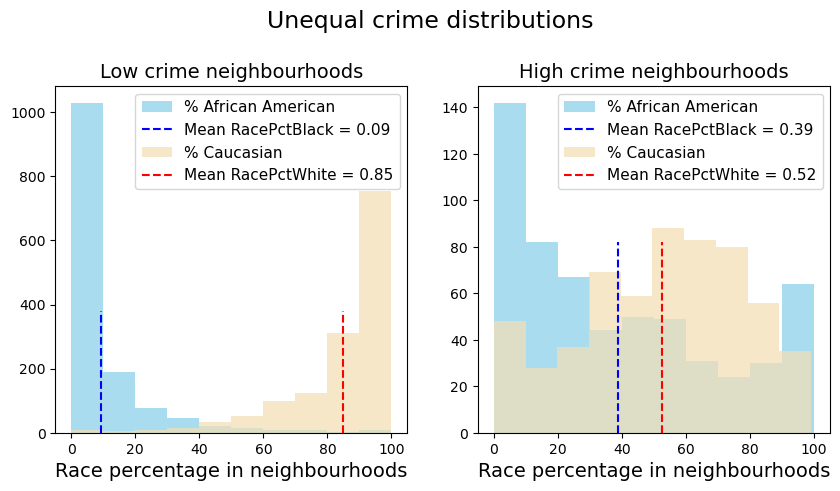

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4.5), sharey = False)
fig.suptitle('Unequal crime distributions', fontsize = 17, y = 1.05)

ax1.hist(black_no_crime, color = 'skyblue', label = "% African American", alpha = 0.7)
ax1.axvline(black_no_crime.values.mean(), ymax=0.35, color = "blue", linestyle = "--", label = f"Mean RacePctBlack = {np.round(black_no_crime.values.mean(),2)}")

ax1.hist(white_no_crime, color = 'wheat', label = "% Caucasian", alpha = 0.7)
ax1.axvline(white_no_crime.values.mean(), ymax=0.35, color = "red", linestyle = "--", label = f"Mean RacePctWhite = {np.round(white_no_crime.values.mean(),2)}")

ax1.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax1.set_xticklabels([0,20,40,60,80,100])
ax1.set_title("Low crime neighbourhoods", fontsize = 14)
ax1.set_xlabel("Race percentage in neighbourhoods", fontsize = 14)
ax1.legend(fontsize = 11)

ax2.hist(black_crime, color = 'skyblue', label = "% African American", alpha = 0.7)
ax2.axvline(black_crime.values.mean(), ymax=0.55, color = "blue", linestyle = "--", label = f"Mean RacePctBlack = {np.round(black_crime.values.mean(),2)}")

ax2.hist(white_crime, color = 'wheat', label = "% Caucasian", alpha = 0.7)
ax2.axvline(white_crime.values.mean(), ymax=0.55, color = "red", linestyle = "--", label = f"Mean RacePctWhite = {np.round(white_crime.values.mean(),2)}")

ax2.set_xticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_xticklabels([0,20,40,60,80,100])
ax2.set_title("High crime neighbourhoods", fontsize = 14)
ax2.legend(fontsize = 11)
ax2.set_xlabel("Race percentage in neighbourhoods", fontsize = 14)

plt.savefig("Plots/Crime_unequal_distributions.png")
plt.show()

#### Histograms split on African American vs non African American

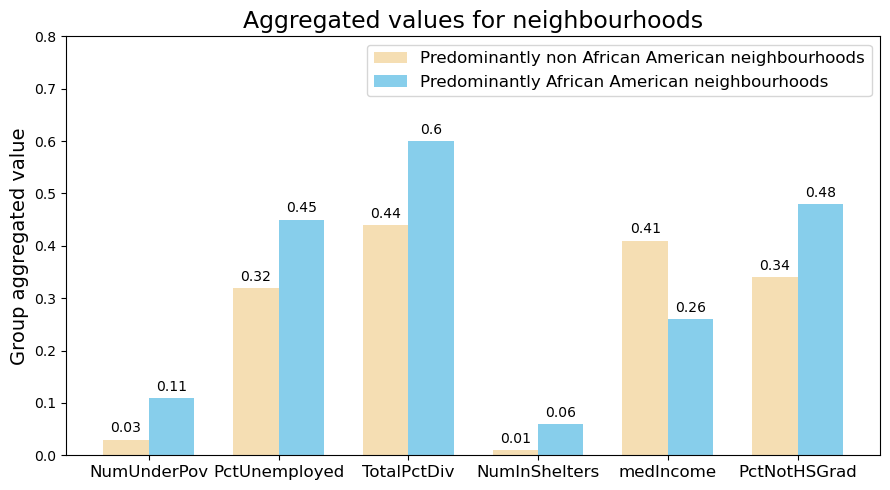

In [17]:
cols_for_hist = ["NumUnderPov", "PctUnemployed", "TotalPctDiv", "NumInShelters", "medIncome", "PctNotHSGrad"]
white_means = []
black_means = []

for i in cols_for_hist:
    white_means.append(np.round(data_full[i][data_full.IsBlack == 0].mean(),2))
    black_means.append(np.round(data_full[i][data_full.IsBlack == 1].mean(),2))

x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (9,5))
rects1 = ax.bar(x - width/2, white_means, width, label='Predominantly non African American neighbourhoods', color = 'wheat')
rects2 = ax.bar(x + width/2, black_means, width, label='Predominantly African American neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Group aggregated value', fontsize = 14)
ax.set_title('Aggregated values for neighbourhoods', fontsize = 17)
ax.set_xticks(x)
ax.set_xticklabels(cols_for_hist, fontsize = 12)
ax.set_ylim(top = 0.8)
ax.legend(fontsize = 12)

autolabel(rects1, ax)
autolabel(rects2, ax)

fig.tight_layout()
plt.savefig("Plots/black_white_aggregate.png")
plt.show()

#### Correlations

Here we work with df_all where we have removed the IsBlack and HighCrime cols (the ones we defined with the threshold)

In [18]:
# Start by calculating correlation in the dataset
corr_dat = np.ones((data_init.shape[1],data_init.shape[1]))
p_values = np.zeros((data_init.shape[1],data_init.shape[1]))

# Fo through all features
features = data_init.keys()
for feature_i in range(len(features)):
    for feature_j in range(feature_i,len(features)):
        if feature_i != feature_j:
            fi = features[feature_i]
            fj = features[feature_j]
            
            # calculate correlation
            r,p = pearsonr(data_init[fi],data_init[fj])
            
            # save correlation values
            corr_dat[feature_i,feature_j] = r
            # because correlation is symmetric we also fill in the other value
            corr_dat[feature_j,feature_i] = r
            
            # save p-values
            p_values[feature_i,feature_j] = p
            # because correlation is symmetric we also fill in the other value
            p_values[feature_j,feature_i] = p

In [19]:
corrected_p_value = 0.05 / (len(features)**2/2)
# Createa a binary p-value-matrix
corrected_p_matrix = np.ones(p_values.shape)
# Threshold it to significant and non-significant
corrected_p_matrix[p_values >= corrected_p_value] = 0

**Calculate crime correlations**

In [20]:
# Let's get the list of the 10 highest correlation between crime and X
num_corr = 10

corr_crime = corr_dat[features.get_loc("ViolentCrimesPerPop")]

features_sorted_crime = [ y for x,y in sorted(zip(corr_crime, features), key = lambda x: abs(x[0]), reverse = True)]
corr_sorted_crime = [ x for x,y in sorted(zip(corr_crime, features), key = lambda x: abs(x[0]), reverse = True)]

features_10_crime = features_sorted_crime[1:(num_corr+1)]
corr_10_crime = corr_sorted_crime[1:(num_corr+1)]

In [21]:
# Check bonferroni is above 0 for all these
p_bonferroni_crime = corrected_p_matrix[features.get_loc("ViolentCrimesPerPop")]
p_bonferroni_sorted_crime = [ y for x,y in sorted(zip(corr_crime, p_bonferroni_crime), key = lambda x: abs(x[0]), reverse = True)]
p_bonferroni_10_crime = p_bonferroni_sorted_crime[1:(num_corr+1)]
p_bonferroni_10_crime

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

**Plot crime correlations**

In [111]:
colours = []
for i in corr_10_crime:
    if i > 0:
        colours.append("firebrick")
    else:
        colours.append("royalblue")

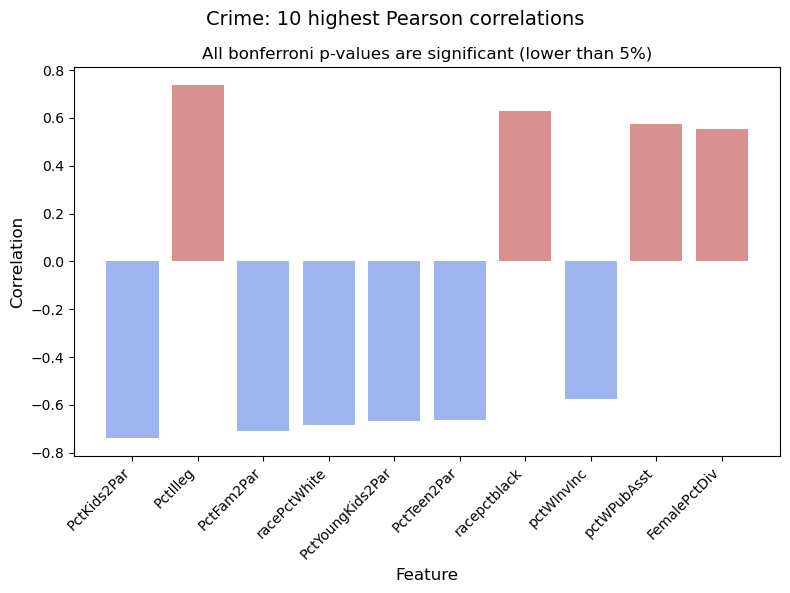

In [112]:
# Plot 10 highest correlations with crime
x_pos = np.arange(len(features_10_crime))

plt.figure(figsize=(8,6))

for i in range(len(x_pos)):
    plt.bar(x_pos[i], corr_10_crime[i], color = colours[i], align='center', alpha=0.5)

plt.xticks(x_pos, features_10_crime, rotation = 45, ha = 'right')
plt.xlabel("Feature", fontsize = 12)
plt.ylabel('Correlation', fontsize = 12)
plt.title(f'All bonferroni p-values are significant (lower than 5%)', fontsize = 12)
plt.suptitle(f'Crime: {num_corr} highest Pearson correlations', fontsize = 14)

plt.savefig("Plots/crime_correlations.png")
plt.tight_layout()
plt.show()

**Calculate pctblack correlations**

In [24]:
# Let's get the list of the 10 highest correlation between crime and X
num_corr = 10

corr_black = corr_dat[features.get_loc("racepctblack")]

features_sorted_black = [ y for x,y in sorted(zip(corr_black, features), key = lambda x: abs(x[0]), reverse = True)]
corr_sorted_black = [ x for x,y in sorted(zip(corr_black, features), key = lambda x: abs(x[0]), reverse = True)]

features_10_black = features_sorted_black[1:(num_corr+1)]
corr_10_black = corr_sorted_black[1:(num_corr+1)]

In [25]:
# Check bonferroni is above 0 for all these
p_bonferroni_black = corrected_p_matrix[features.get_loc("racepctblack")]
p_bonferroni_sorted_black = [ y for x,y in sorted(zip(corr_black, p_bonferroni_black), key = lambda x: abs(x[0]), reverse = True)]
p_bonferroni_10_black = p_bonferroni_sorted_black[1:(num_corr+1)]
p_bonferroni_10_black

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

**Plot pctblack correlations**

In [26]:
colours_black = []
for i in corr_10_black:
    if i > 0:
        colours_black.append("firebrick")
    else:
        colours_black.append("royalblue")

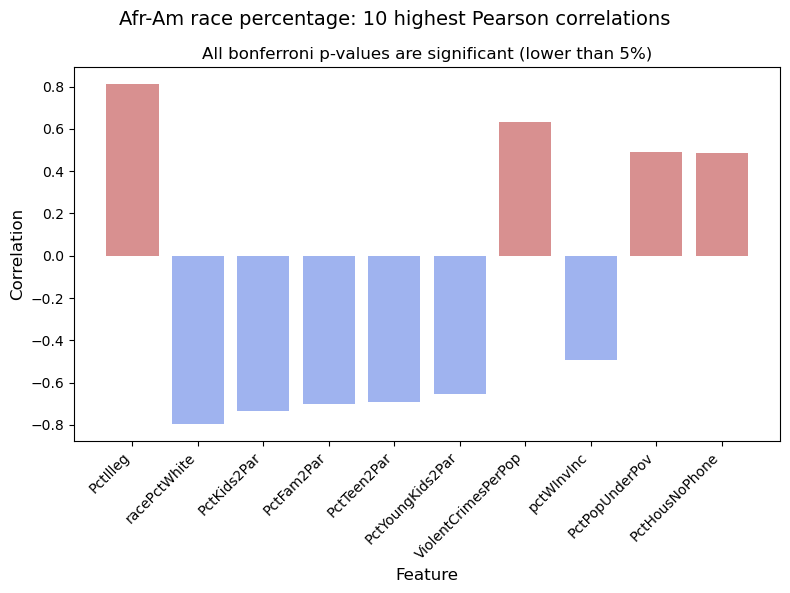

In [27]:
# Plot 10 highest correlations with crime
x_pos = np.arange(len(features_10_black))

plt.figure(figsize=(8,6))

for i in range(len(x_pos)):
    plt.bar(x_pos[i], corr_10_black[i], color = colours_black[i], align='center', alpha=0.5)

plt.xticks(x_pos, features_10_black, rotation = 45, ha = 'right')
plt.xlabel("Feature", fontsize = 12)
plt.ylabel('Correlation', fontsize = 12)
plt.title(f'All bonferroni p-values are significant (lower than 5%)', fontsize = 12)
plt.suptitle(f'Afr-Am race percentage: {num_corr} highest Pearson correlations', fontsize = 14)

plt.savefig("Plots/blackness_correlations.png")
plt.tight_layout()
plt.show()

# Baseline models

In [28]:
X, y = data, data_y["HighCrime"]
IsBlack = data_full.IsBlack == 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Logreg

In [29]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [30]:
X, y = data, data_y["HighCrime"]
IsBlack = data_full.IsBlack == 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [31]:
scaler = scaling_func(preprocessing.StandardScaler)

In [32]:
model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}
logreg_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

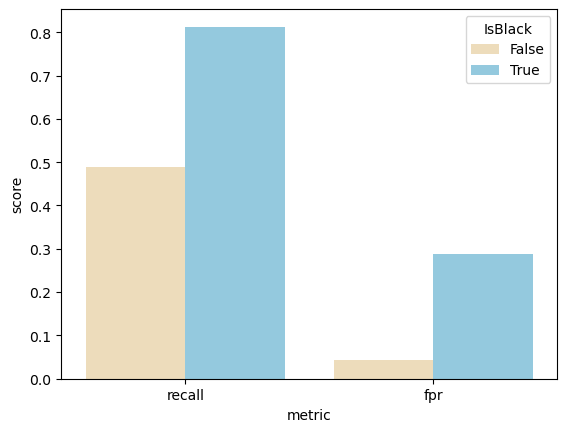

In [33]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], logreg_preds[IsBlack])
logreg_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], logreg_preds[~IsBlack])
logreg_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
logreg_tmp_df = pd.concat([logreg_tmp_df_1, logreg_tmp_df_2])

sns.barplot(data=logreg_tmp_df, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [34]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], logreg_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], logreg_preds[IsBlack]))
print(classification_report(y, logreg_preds))

0.8921496698459281
0.7749603803486529
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1411
           1       0.78      0.71      0.74       583

    accuracy                           0.86      1994
   macro avg       0.83      0.81      0.82      1994
weighted avg       0.85      0.86      0.85      1994



### Decision tree

In [35]:
X, y = data, data_y["HighCrime"]
IsBlack = data_full.IsBlack == 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [36]:
scaler = scaling_func(preprocessing.StandardScaler)

In [37]:
model = DecisionTreeClassifier
model_params = {"random_state":1}

dt_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

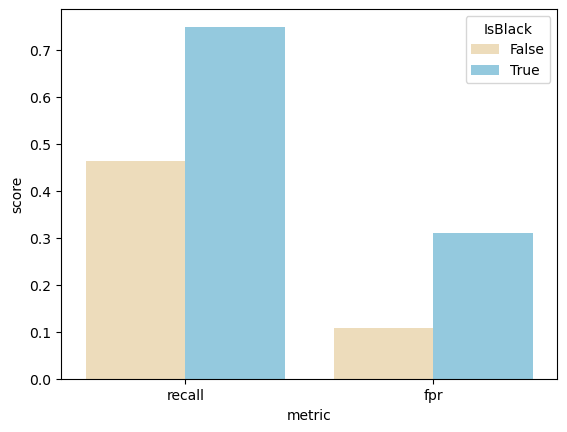

In [38]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], dt_preds[IsBlack])
dt_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], dt_preds[~IsBlack])
dt_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
dt_tmp_df = pd.concat([dt_tmp_df_1, dt_tmp_df_2])

sns.barplot(data=dt_tmp_df, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [39]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], dt_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], dt_preds[IsBlack]))
print(classification_report(y, dt_preds))

0.8319882611885546
0.7274167987321711
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1411
           1       0.66      0.66      0.66       583

    accuracy                           0.80      1994
   macro avg       0.76      0.76      0.76      1994
weighted avg       0.80      0.80      0.80      1994



# Debias data, model performance

In [40]:
# Initialize X (without the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

## Logreg

In [41]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [42]:
model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}
debias_logreg_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

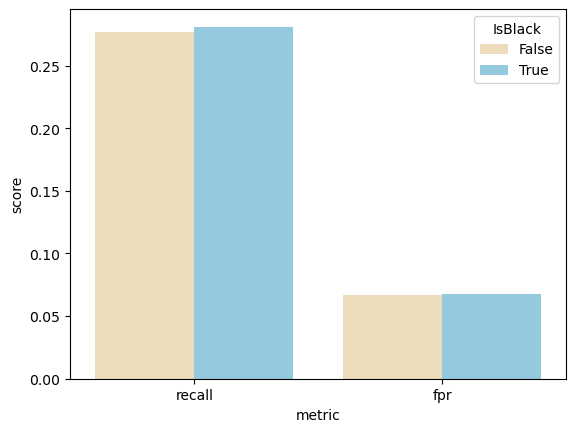

In [43]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], debias_logreg_preds[IsBlack])
debias_log_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], debias_logreg_preds[~IsBlack])
debias_log_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
logreg_tmp_df_reproject = pd.concat([debias_log_tmp_df_1, debias_log_tmp_df_2])

sns.barplot(data=logreg_tmp_df_reproject, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [44]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], debias_logreg_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], debias_logreg_preds[IsBlack]))
print(classification_report(y, debias_logreg_preds))

0.8422597212032281
0.5245641838351822
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1411
           1       0.63      0.28      0.39       583

    accuracy                           0.74      1994
   macro avg       0.69      0.61      0.61      1994
weighted avg       0.72      0.74      0.71      1994



## Decision Tree

In [45]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [46]:
model = DecisionTreeClassifier
model_params = {"random_state":1}
debias_dt_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

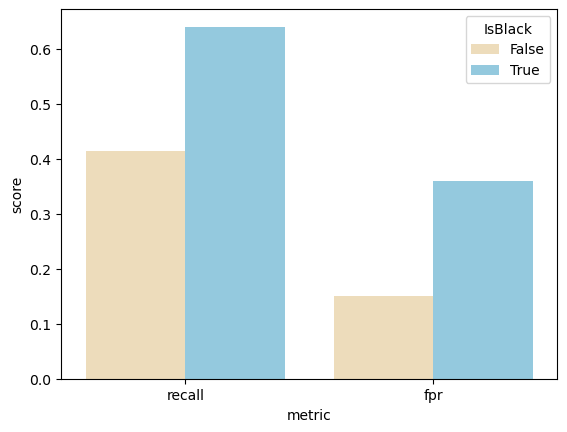

In [47]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], debias_dt_preds[IsBlack])
debias_dt_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], debias_dt_preds[~IsBlack])
debias_dt_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
dt_tmp_df_reproject = pd.concat([debias_dt_tmp_df_1, debias_dt_tmp_df_2])

sns.barplot(data=dt_tmp_df_reproject, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [48]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], debias_dt_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], debias_dt_preds[IsBlack]))
print(classification_report(y, debias_dt_preds))

0.789435069699193
0.6402535657686212
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1411
           1       0.56      0.57      0.56       583

    accuracy                           0.74      1994
   macro avg       0.69      0.69      0.69      1994
weighted avg       0.74      0.74      0.74      1994



# Regular data vs. debias data

## Logreg

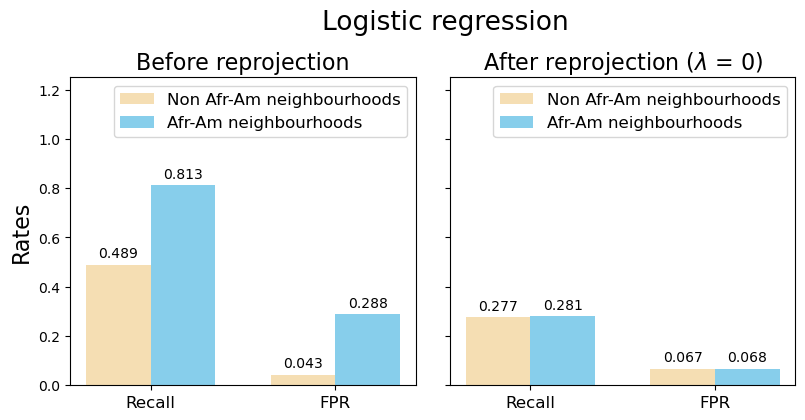

In [49]:
import matplotlib.gridspec as gridspec
# Plot equalized odds for black vs non-black neighbourhoods

white_neig_eq_odds_before = np.round(logreg_tmp_df[logreg_tmp_df.IsBlack == 0].score.values,3)
black_neig_eq_odds_before = np.round(logreg_tmp_df[logreg_tmp_df.IsBlack == 1].score.values,3)

white_neig_eq_odds_after = np.round(logreg_tmp_df_reproject[logreg_tmp_df_reproject.IsBlack == 0].score.values,3)
black_neig_eq_odds_after = np.round(logreg_tmp_df_reproject[logreg_tmp_df_reproject.IsBlack == 1].score.values,3)

cols_for_hist = ["Recall", "FPR"]
x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4), sharey = True)
plt.subplots_adjust(wspace=0.1, hspace=0, right=.85)

plt.suptitle("Logistic regression", fontsize = 19, y = 1.05)
rects1 = ax1.bar(x - width/2, white_neig_eq_odds_before, width, label='Non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax1.bar(x + width/2, black_neig_eq_odds_before, width, label='Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Rates', fontsize = 16)
ax1.set_title('Before reprojection', fontsize = 16)
ax1.set_xticks(x)
ax1.set_xticklabels(cols_for_hist, fontsize = 12)
ax1.set_ylim(top = 0.5)
ax1.legend(fontsize = 12)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Plot equalized odds for black vs non-black neighbourhoods
rects1 = ax2.bar(x - width/2, white_neig_eq_odds_after, width, label='Non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax2.bar(x + width/2, black_neig_eq_odds_after, width, label='Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title(f'After reprojection ($\lambda$ = 0)', fontsize = 16)
ax2.set_xticks(x)
ax2.set_xticklabels(cols_for_hist, fontsize = 12)
ax2.set_ylim(top = 1.25)
ax2.legend(fontsize = 12)

autolabel(rects1, ax2)
autolabel(rects2, ax2)

#fig.tight_layout()
plt.savefig("Plots/eq_odds_before_after_reproject_logreg.png")
plt.show()

## Decision tree

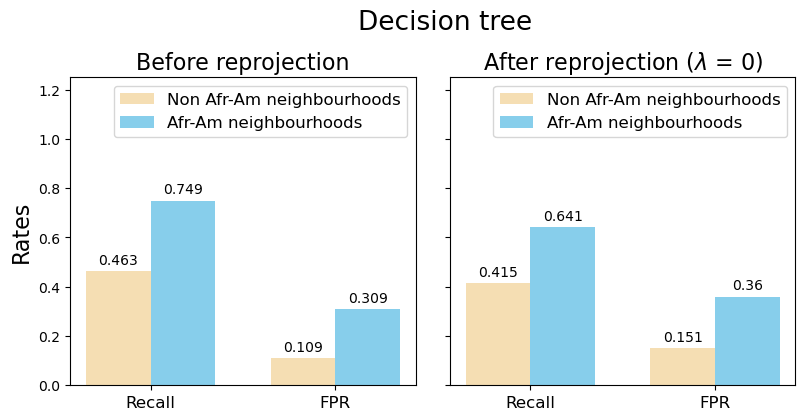

In [50]:
import matplotlib.gridspec as gridspec
# Plot equalized odds for black vs non-black neighbourhoods

white_neig_eq_odds_before = np.round(dt_tmp_df[dt_tmp_df.IsBlack == 0].score.values,3)
black_neig_eq_odds_before = np.round(dt_tmp_df[dt_tmp_df.IsBlack == 1].score.values,3)

white_neig_eq_odds_after = np.round(dt_tmp_df_reproject[dt_tmp_df_reproject.IsBlack == 0].score.values,3)
black_neig_eq_odds_after = np.round(dt_tmp_df_reproject[dt_tmp_df_reproject.IsBlack == 1].score.values,3)

cols_for_hist = ["Recall", "FPR"]
x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,4), sharey = True)
plt.subplots_adjust(wspace=0.1, hspace=0, right=.85)

plt.suptitle("Decision tree", fontsize = 19, y = 1.05)
rects1 = ax1.bar(x - width/2, white_neig_eq_odds_before, width, label='Non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax1.bar(x + width/2, black_neig_eq_odds_before, width, label='Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Rates', fontsize = 16)
ax1.set_title('Before reprojection', fontsize = 16)
ax1.set_xticks(x)
ax1.set_xticklabels(cols_for_hist, fontsize = 12)
ax1.set_ylim(top = 0.5)
ax1.legend(fontsize = 12)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Plot equalized odds for black vs non-black neighbourhoods
rects1 = ax2.bar(x - width/2, white_neig_eq_odds_after, width, label='Non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax2.bar(x + width/2, black_neig_eq_odds_after, width, label='Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title(f'After reprojection ($\lambda$ = 0)', fontsize = 16)
ax2.set_xticks(x)
ax2.set_xticklabels(cols_for_hist, fontsize = 12)
ax2.set_ylim(top = 1.25)
ax2.legend(fontsize = 12)

autolabel(rects1, ax2)
autolabel(rects2, ax2)

#fig.tight_layout()
plt.savefig("Plots/eq_odds_before_after_reproject_dt.png")
plt.show()

# Hyper param tuning

In [51]:
def remove_protected(protected_cols):
    def call(X_train, X_test):
        return X_train.drop(columns=protected_cols), X_test.drop(columns=protected_cols)
    return call

In [52]:
# Initialize X (without the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y['HighCrime']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create dataset without protected columns
scaler_nonprot = remove_protected(protected_cols)
X_train_nonprot, X_test_wo_prot = scaler_nonprot(X_train, X_test)

# Create debiased dataset
l_value = 0
scaler_debias = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
X_train_debiased, X_test_debiased = scaler_debias(X_train, X_test)
X_train_debiased = pd.DataFrame(X_train_debiased, columns=nonprotected_cols)

# Scale features
scaler_logreg = scaling_func(preprocessing.StandardScaler)
X_train_logreg, X_test_logreg = scaler_logreg(X_train, X_test)
X_train_logreg, X_test_logreg = pd.DataFrame(X_train_logreg, columns=X_train.columns), pd.DataFrame(X_test_logreg, columns=X_train.columns)

# Create scaled dataset without protected columns
X_train_nonprot, X_test_wo_prot = scaler_nonprot(X_train_logreg, X_test_logreg)

### Logreg

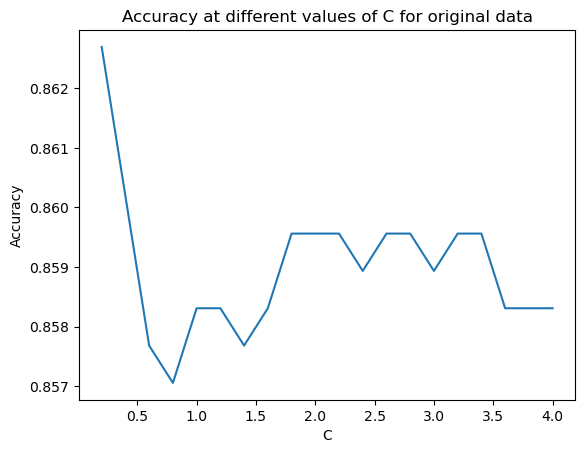

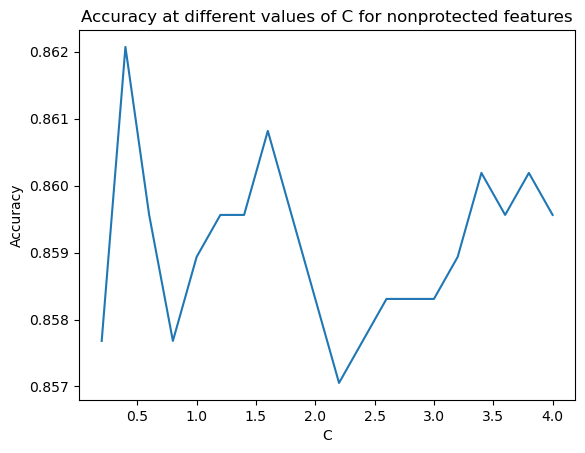

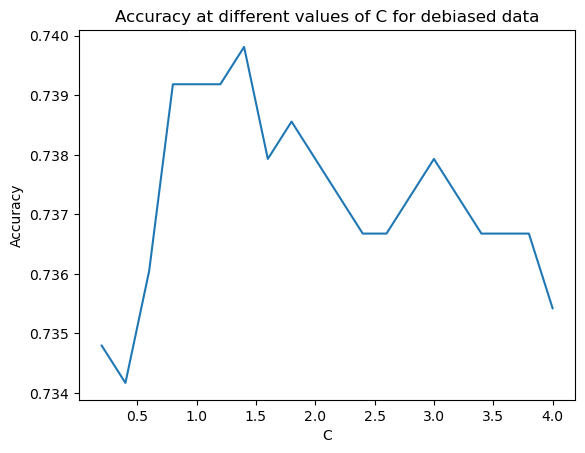

In [53]:
# Define model
model = LogisticRegression

# Find optimal C
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
descriptions = ['original data', 'nonprotected features', 'debiased data']
for scaler, desc in zip([None, scaler_nonprot, scaler_debias], descriptions):
    depths = np.linspace(0.2,4,20)
    scores = []
    for i in depths:
        model_params = {'random_state':1, 'C':i, 'max_iter':500}
        preds = test_model(model, X_train, y_train, kfold, scaler=scaler, model_params=model_params)
        acc = accuracy_score(preds, y_train)
        scores.append(acc)

    # Plot accuracy at each value of C
    plt.plot(depths, scores)
    plt.title(f'Accuracy at different values of C for {desc}')
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.show()

### Decision tree

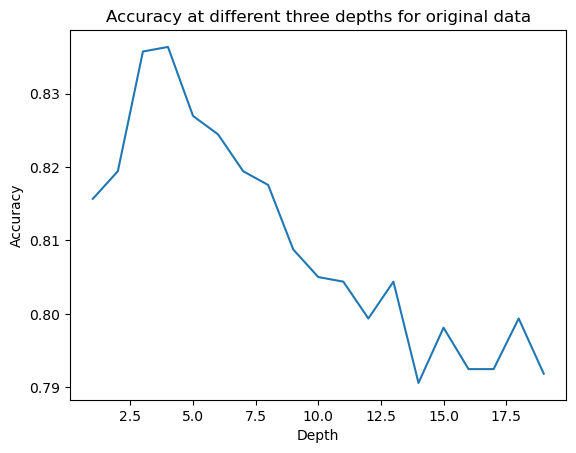

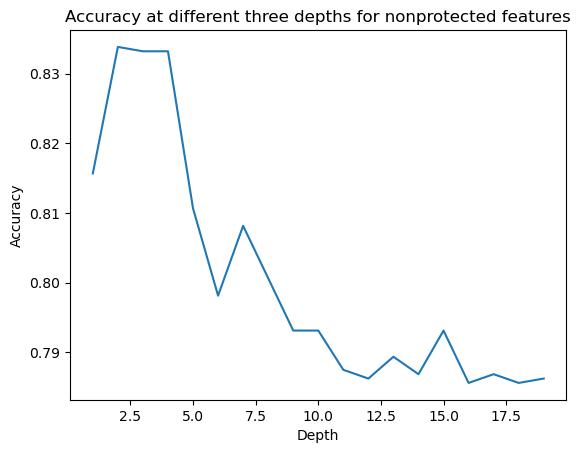

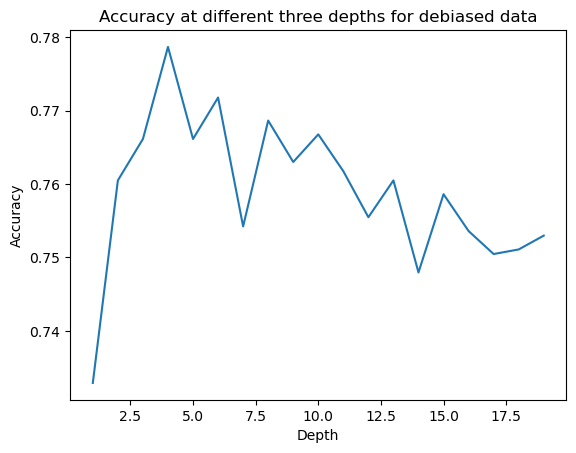

In [54]:
# Define model
model2 = DecisionTreeClassifier

# Find optimal depth of threes
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
descriptions = ['original data', 'nonprotected features', 'debiased data']
for scaler, desc in zip([None, scaler_nonprot, scaler_debias], descriptions):
    depths = [i for i in range(1, 20)]
    scores = []
    for i in depths:
        model_params = {'random_state':1, 'max_depth':i}
        preds = test_model(model2, X_train, y_train, kfold, scaler=scaler, model_params=model_params)
        acc = accuracy_score(preds, y_train)
        scores.append(acc)

    # Plot accuracy at each depth
    plt.plot(depths, scores)
    plt.title(f'Accuracy at different three depths for {desc}')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.show()

# Model explainability analysis

In [55]:
colors = ["orangered", "wheat", "deepskyblue"]
cmap = LinearSegmentedColormap.from_list("cmap_name", colors, N=50)

### Logreg

In [56]:
# Fit model
X_splits = [X_train, X_train_nonprot, X_train_debiased]
C = 1.0
model_instances = []
for X_split in X_splits:
    model_instance = model(C=C, random_state=1, max_iter=500)
    model_instance.fit(X=X_split, y=y_train)
    model_instances.append(model_instance)

# Get importance of each feature
top_k = 7
columns = [protected_cols+nonprotected_cols, nonprotected_cols, nonprotected_cols]
indices = []
print('Feature importances for model trained on..')
for model_instance, cols, description in zip(model_instances, columns, descriptions):
    importances = model_instance.coef_[0]
    index = np.argsort(-abs(importances))
    indices.append(index)
    print(f'\t{description}:')
    for feature, importance in zip(np.array(cols)[index][:top_k], importances[index][:top_k]):
        print(f'\t\t{feature}: {importance:.5f}')

Feature importances for model trained on..
	original data:
		PctIlleg: 1.76710
		PctHousOccup: -1.51941
		HousVacant: 1.48218
		racePctHisp: -1.45526
		MedOwnCostPctIncNoMtg: -1.38735
		MedRentPctHousInc: 1.26144
		pctWInvInc: -1.21938
	nonprotected features:
		MedRent: 1.37189
		PctKids2Par: -1.09826
		RentLowQ: -1.04313
		PctRecImmig10: -1.02663
		PctPopUnderPov: -0.94407
		PctForeignBorn: 0.86720
		PctWorkMom: -0.84658
	debiased data:
		PctRecImmig10: -0.96626
		PctForeignBorn: 0.80063
		MedRent: 0.74327
		PctNotSpeakEnglWell: -0.67119
		RentLowQ: -0.65524
		population: 0.64662
		PctIlleg: 0.61539


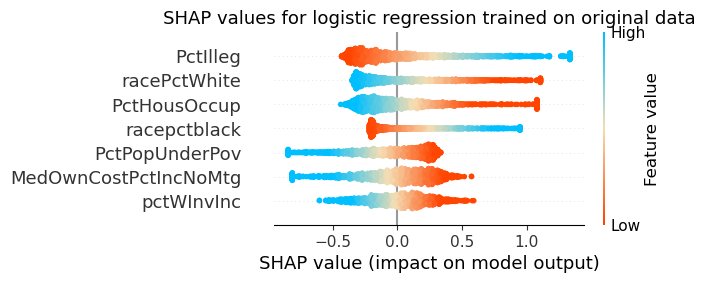

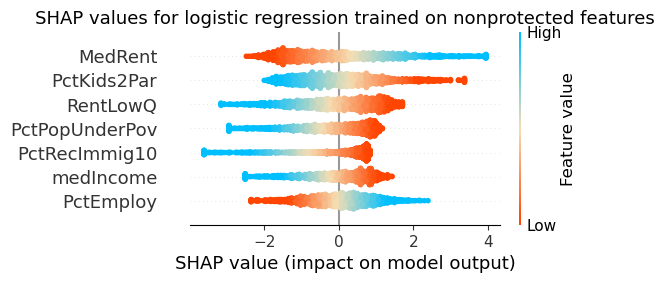

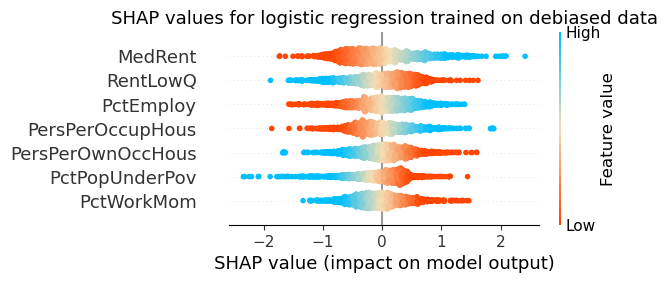

In [57]:
# Plot Shap values of logistic model
for i, (model_instance, X_split, index, description) in enumerate(zip(model_instances, X_splits, indices, descriptions)):
    explainer = shap.LinearExplainer(model_instance, X_split)
    shap_values = explainer.shap_values(X_split)
    plot = shap.summary_plot(shap_values, X_split, feature_names=X_split.columns, max_display=top_k, plot_size=(5,2.5), cmap=cmap, show=False)
    plt.title(f'SHAP values for logistic regression trained on {description}', fontsize=13)
    # Make the color bar visible
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    plt.savefig(f'Plots/shap_lr_{i}.png', bbox_inches='tight')
    plt.gcf()
    plt.show()

### Decision tree

In [58]:
# Fit model
X_splits = [X_train, X_train_nonprot, X_train_debiased]
max_depth = 3
model_instances = []
for X_split in X_splits:
    model_instance = model2(max_depth=max_depth, random_state=1)
    model_instance.fit(X=X_split, y=y_train)
    model_instances.append(model_instance)

# Get importance of each feature
top_k = 7
columns = [protected_cols+nonprotected_cols, nonprotected_cols, nonprotected_cols]
indices = []
f_importances = []
print('Feature importances for model trained on..')
for model_instance, cols, description in zip(model_instances, columns, descriptions):
    importances = model_instance.feature_importances_
    f_importances.append(importances)
    index = np.argsort(-importances)
    indices.append(index)
    print(f'\t{description}:')
    for feature, importance in zip(np.array(cols)[index][:top_k], importances[index][:top_k]):
        print(f'\t\t{feature}: {importance:.5f}')

Feature importances for model trained on..
	original data:
		PctIlleg: 0.72103
		NumIlleg: 0.11552
		PctPopUnderPov: 0.05723
		PctKids2Par: 0.04849
		PctNotSpeakEnglWell: 0.03202
		racePctHisp: 0.01978
		householdsize: 0.00593
	nonprotected features:
		PctIlleg: 0.72195
		NumIlleg: 0.11566
		PctPopUnderPov: 0.05730
		PctKids2Par: 0.04855
		PctNotSpeakEnglWell: 0.03206
		pctWInvInc: 0.01854
		NumUnderPov: 0.00594
	debiased data:
		NumIlleg: 0.71862
		PctFam2Par: 0.11947
		LemasPctOfficDrugUn: 0.08296
		MedNumBR: 0.03067
		RentLowQ: 0.02540
		pctWFarmSelf: 0.02287
		PctHousOccup: 0.00000


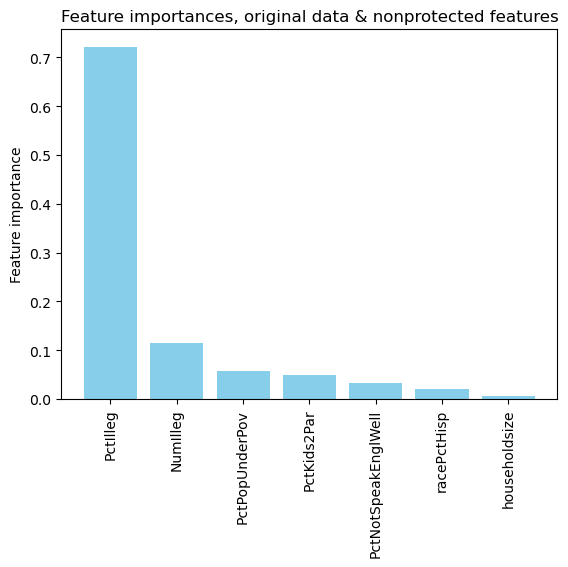

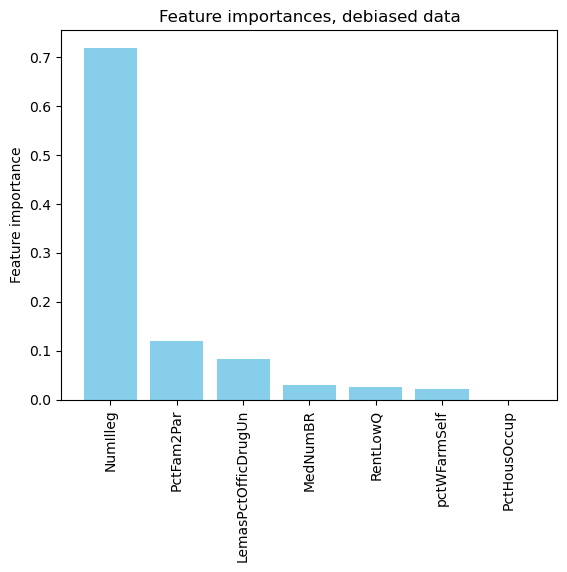

In [59]:
def plot_feature_importances(top_k, model_idx, columns, indices, f_importances, plot_title, savefig_title):
    plt.bar(np.array(columns[model_idx])[indices[model_idx][:top_k]], f_importances[model_idx][indices[model_idx][:top_k]], color = 'skyblue')
    plt.xticks(rotation=90)
    plt.title(plot_title)
    plt.ylabel('Feature importance')
    plt.savefig(f'Plots/{savefig_title}', bbox_inches='tight')
    plt.show()

plot_feature_importances(top_k, 0, columns, indices, f_importances, 'Feature importances, original data & nonprotected features', 'feat_imp_dt_orig.png')
plot_feature_importances(top_k, 2, columns, indices, f_importances, 'Feature importances, debiased data', 'feat_imp_dt_debiased.png')

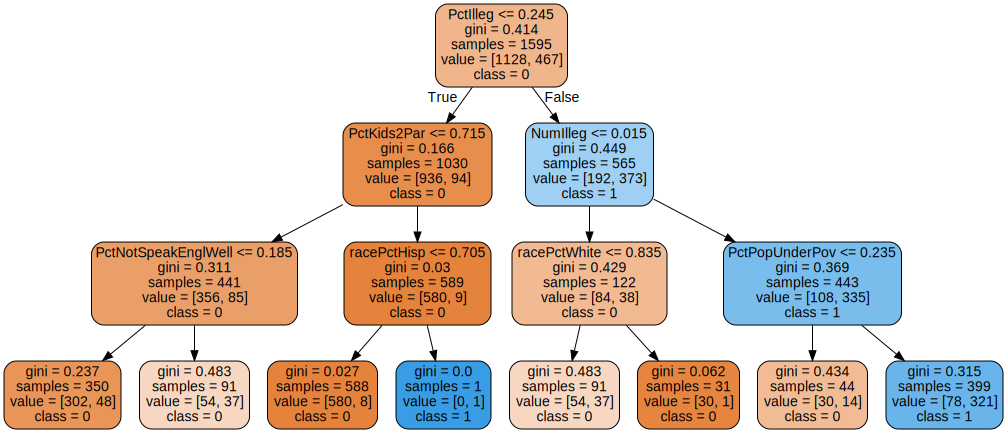

In [60]:
# Visualize decision tree for original data
graph = Source(export_graphviz(model_instances[0], feature_names=X_train.columns, class_names=model_instances[0].classes_.astype(str), filled=True, rounded=True)  
)
# graph.format = 'png'
# graph.render('tree_orig', view=True)
graph

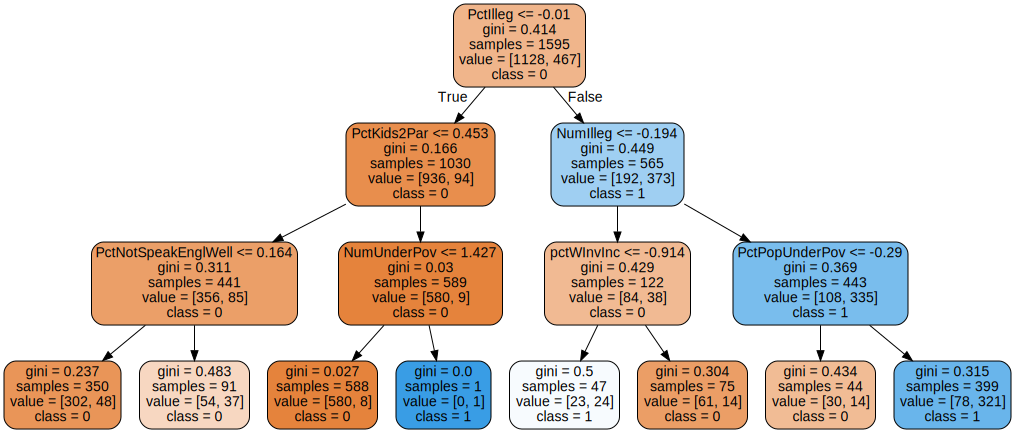

In [61]:
# Visualize decision tree for nonprotected features
graph = Source(export_graphviz(model_instances[1], feature_names=X_train_nonprot.columns, class_names=model_instances[1].classes_.astype(str), filled=True, rounded=True)  
)
# graph.format = 'png'
# graph.render('tree_nonprot', view=True)
graph

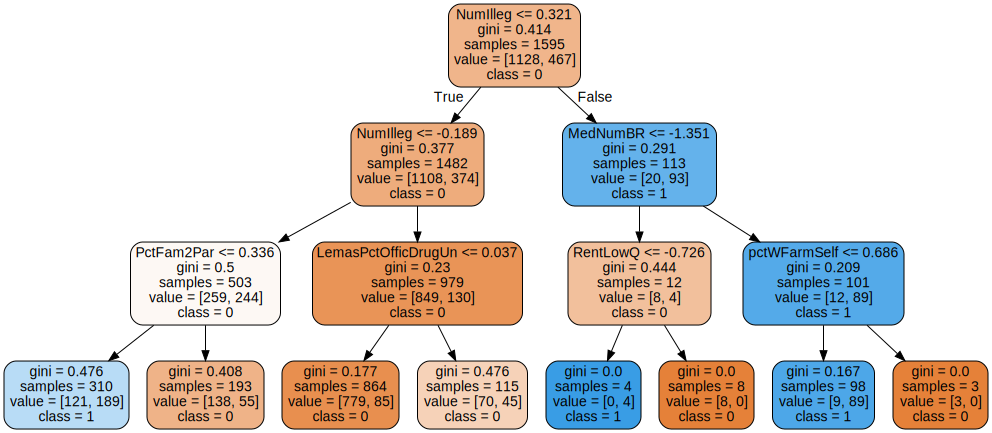

In [62]:
# Visualize decision tree for debiased data
graph = Source(export_graphviz(model_instances[2], feature_names=X_train_debiased.columns, class_names=model_instances[2].classes_.astype(str), filled=True, rounded=True)  
)
# graph.format = 'png'
# graph.render('tree_debias', view=True)
graph

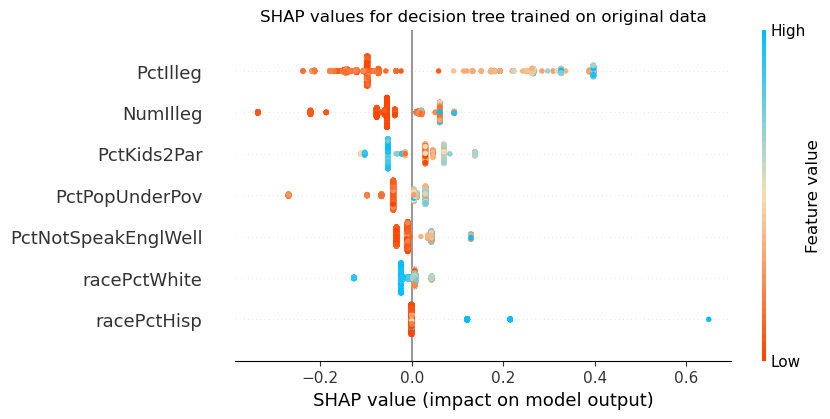

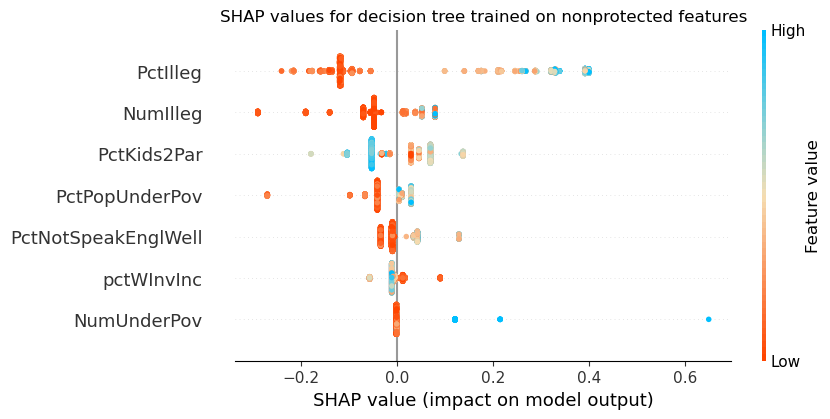

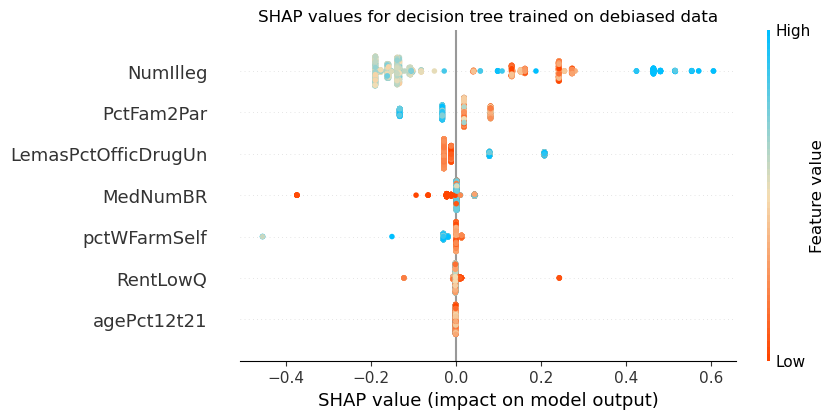

In [63]:
# Plot Shap values of decision tree model
for model_instance, X_split, index, description in zip(model_instances, X_splits, indices, descriptions):
    explainer = shap.TreeExplainer(model=model_instance)
    shap_values = explainer.shap_values(X_split)
    plot = shap.summary_plot(shap_values[1], X_split, max_display=top_k, cmap=cmap, show=False)
    # Make the color bar visible
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    plt.title(f'SHAP values for decision tree trained on {description}')
    plt.show()

# Debiasing data lambda tuning

### Logreg lambda tunning pareto front

In [64]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [65]:
lambda_values = np.linspace(1,0,30)

In [66]:
predictions = {}
result_metrics = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    model = LogisticRegression
    model_params = {"max_iter":500, "random_state":1}

    preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)
    predictions[f"{l_value:.2f}"] = preds
    
    acc_black = accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    acc_non_black = accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    recall_black, fpr_black = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    recall_non_black, fpr_non_black = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    num_high_black = np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])
    num_highn_non_black = np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])
    result_metrics[f"{l_value:.2f}"] = {"acc_black":acc_black,
                                        "acc_non_black": acc_non_black,
                                        "recall_black":recall_black, 
                                        "recall_non_black":recall_non_black,
                                         "fpr_black": fpr_black,
                                         "fpr_non_black": fpr_non_black,
                                        "num_high_black":num_high_black,
                                       "num_highn_non_black":num_highn_non_black}

100%|██████████| 30/30 [04:57<00:00,  9.92s/it]


In [67]:
makro_acc = []
equal_odds_mse = []
for key, res in result_metrics.items():
    m_acc = (res["acc_black"] + res["acc_non_black"])/2
    se_recall = (res["recall_black"] - res["recall_non_black"])**2
    se_fpr = (res["fpr_black"] - res["fpr_non_black"])**2
    mse_total = (se_recall + se_fpr)/2
    
    makro_acc.append(m_acc)
    equal_odds_mse.append(mse_total)

In [68]:
annotate_ax = [0, 7, 12, 18, 20, 23, 25, 29]
y_upper = [x + 10 for x in equal_odds_mse]

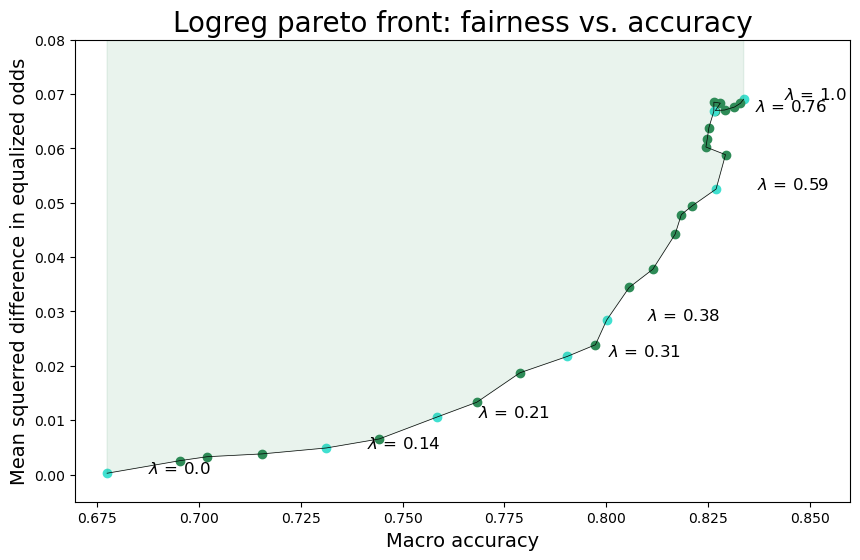

In [69]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(makro_acc, equal_odds_mse, color = "black", linewidth = 0.5)

for j in np.arange(0,len(lambda_values),1):
    if j in annotate_ax:
        color = 'turquoise'
    else: 
        color = 'seagreen'
    ax.scatter(makro_acc[j], equal_odds_mse[j], color = color)

for i in annotate_ax:
    ax.annotate("$\lambda$ = "+str(np.round(lambda_values[i],2)), (makro_acc[i] + 0.01, equal_odds_mse[i]), fontsize = 12)

ax.fill_between(makro_acc, equal_odds_mse, y_upper, color = "seagreen", alpha = 0.1)

ax.set_xlim(right = 0.86)
ax.set_ylim(bottom = -0.005, top = 0.08)

plt.title("Logreg pareto front: fairness vs. accuracy", fontsize = 20)
plt.xlabel(r"Macro accuracy", fontsize = 14)
plt.ylabel("Mean squerred difference in equalized odds", fontsize = 14)

plt.savefig("Plots/logreg_pareto.png")
plt.show()

## Decision tree lambda tunning pareto front

In [70]:
predictions = {}
result_metrics = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    model = DecisionTreeClassifier
    model_params = {"random_state":1}

    preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)
    predictions[f"{l_value:.2f}"] = preds
    
    acc_black = accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    acc_non_black = accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    recall_black, fpr_black = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    recall_non_black, fpr_non_black = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    num_high_black = np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])
    num_highn_non_black = np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])
    result_metrics[f"{l_value:.2f}"] = {"acc_black":acc_black,
                                        "acc_non_black": acc_non_black,
                                        "recall_black":recall_black, 
                                        "recall_non_black":recall_non_black,
                                         "fpr_black": fpr_black,
                                         "fpr_non_black": fpr_non_black,
                                        "num_high_black":num_high_black,
                                       "num_highn_non_black":num_highn_non_black}

100%|██████████| 30/30 [05:24<00:00, 10.82s/it]


In [71]:
makro_acc = []
equal_odds_mse = []
for key, res in result_metrics.items():
    m_acc = (res["acc_black"] + res["acc_non_black"])/2
    se_recall = (res["recall_black"]- res["recall_non_black"])**2
    se_fpr = (res["fpr_black"] - res["fpr_non_black"])**2
    mse_total = (se_recall + se_fpr)/2
    
    makro_acc.append(m_acc)
    equal_odds_mse.append(mse_total)

In [72]:
annotate_ax = [0, 7, 12, 18, 20, 23, 25, 29]
y_upper = [x + 10 for x in equal_odds_mse]

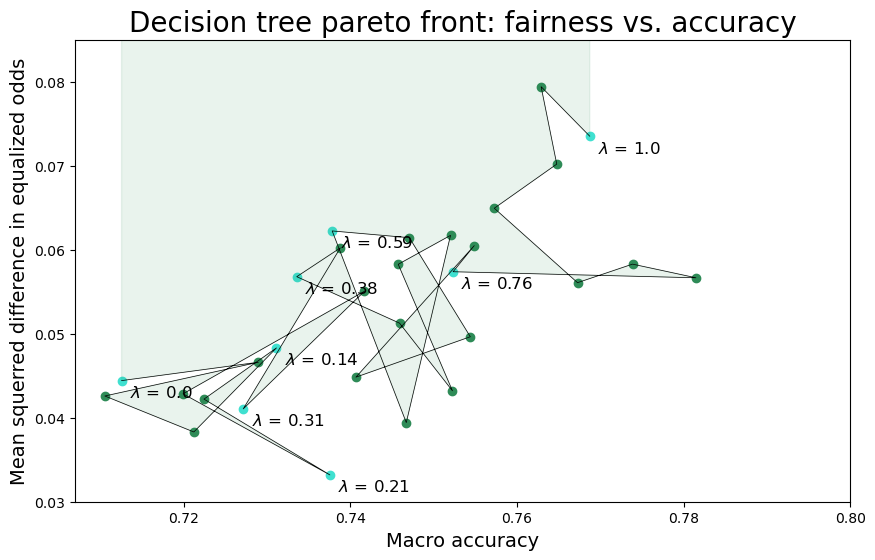

In [73]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(makro_acc, equal_odds_mse, color = "black", linewidth = 0.5)

for j in np.arange(0,len(lambda_values),1):
    if j in annotate_ax:
        color = 'turquoise'
    else: 
        color = 'seagreen'
    ax.scatter(makro_acc[j], equal_odds_mse[j], color = color)

for i in annotate_ax:
    ax.annotate("$\lambda$ = "+str(np.round(lambda_values[i],2)), (makro_acc[i] + 0.001, equal_odds_mse[i]-0.002), fontsize = 12)

ax.fill_between(makro_acc, equal_odds_mse, y_upper, color = "seagreen", alpha = 0.1)

ax.set_xlim(right = 0.8)
ax.set_ylim(bottom = 0.03, top = 0.085)

plt.title("Decision tree pareto front: fairness vs. accuracy", fontsize = 20)
plt.xlabel(r"Macro accuracy", fontsize = 14)
plt.ylabel("Mean squerred difference in equalized odds", fontsize = 14)

plt.savefig("Plots/tree_pareto.png")
plt.show()

# Correlation analysis

In [74]:
# Most important features
dt_raw = ["PctIlleg", "NumIlleg", "PctPopUnderPov", "PctKids2Par", "PctNotSpeakEnglWell", "householdsize"]

dt_debias = ["PctIlleg", "MedNumBR", "PctPersDenseHous", "NumIlleg", "PctNotSpeakEnglWell", "pctWSocSec"]

logreg_raw = ["PctIlleg", "PctHousOccup", "HousVacant", "MedOwnCostPctIncNoMtg", "MedRentPctHousInc", "pctWInvInc", "PctPopUnderPov", "PctWorkMom"]
logreg_debias = ["whitePerCap", "PctKids2Par", "PctIlleg", "PctPersDenseHous", "perCapInc", "PersPerFam", "PctNotSpeakEnglWell", "PctSpeakEnglOnly", "MedRent", "PctRecImmig10"]
most_important_featureas = list(set(logreg_raw + logreg_raw + dt_raw + dt_debias))

In [75]:
len(most_important_featureas)

15

In [76]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]
org_df = X.copy()
org_df[y_cols] = data_y.copy()

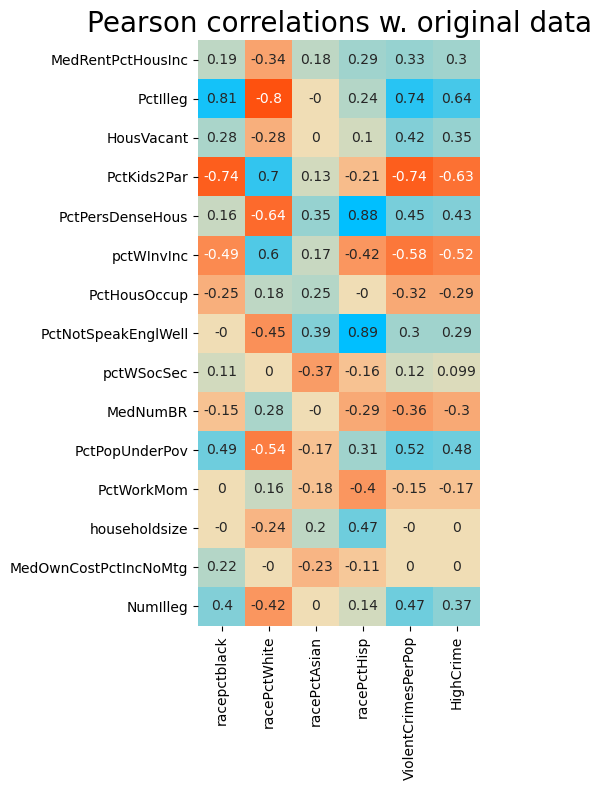

In [77]:
# Same, just showing the protected columns
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(get_significant_correlations(org_df)[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Pearson correlations w. original data", fontsize = 20)
plt.tight_layout()
plt.savefig("Plots/pcorr_org_data_important_features.png")
plt.show()

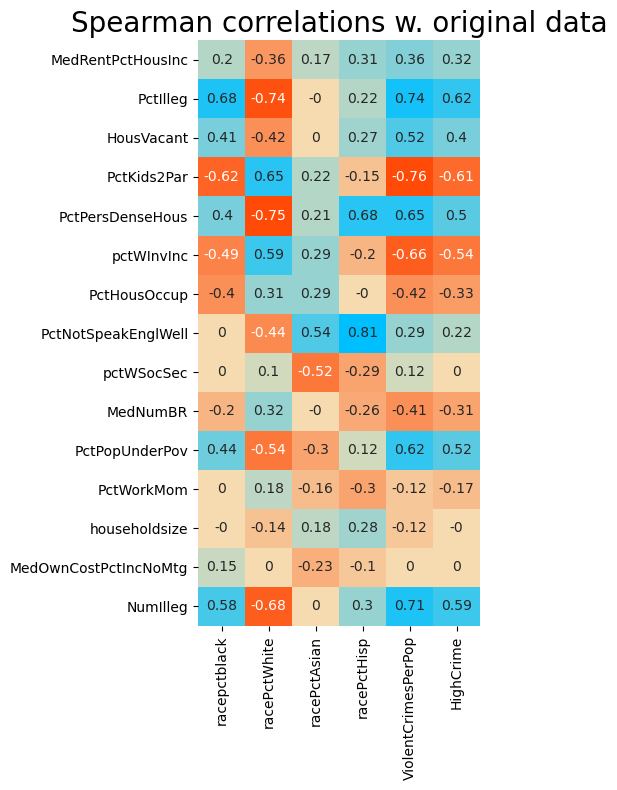

In [78]:
# Spearman
# Same, just showing the protected columns
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(get_significant_correlations(org_df, method="spearman")[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Spearman correlations w. original data", fontsize = 20)
plt.tight_layout()
plt.savefig("Plots/scorr_org_data_important_features.png")
plt.show()

## Debiased data corrs

In [79]:
debias_df = data_full.copy().drop(columns=y_cols)
debias_array, _ = debias_data(protected_cols, nonprotected_cols)(debias_df, debias_df)

In [80]:
# Add the protected columns and the target columns to the debiased data frame for comparison
debias_df = pd.DataFrame(debias_array, columns=nonprotected_cols)
debias_df[y_cols] = data_y
debias_df[protected_cols] = data_full[protected_cols]

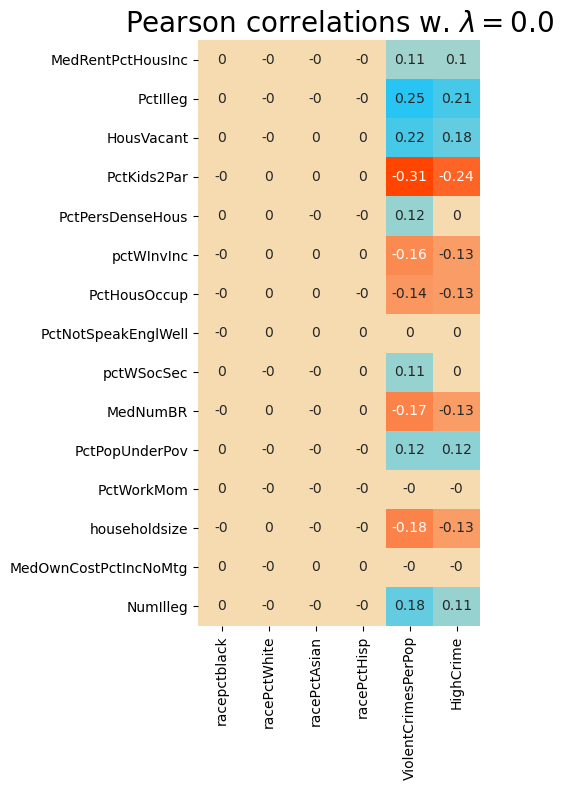

In [81]:
# Show the pearson correlations
pearson_corr = get_significant_correlations(debias_df, cluster=False)
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(pearson_corr[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Pearson correlations w. $\lambda=0.0$", fontsize = 20)
plt.tight_layout()
plt.savefig("Plots/pcorr_debias_data_important_features.png")
plt.show()

In [82]:
# Speanman corr matrix
speaman_corr = get_significant_correlations(debias_df, cluster=False, method="spearman")

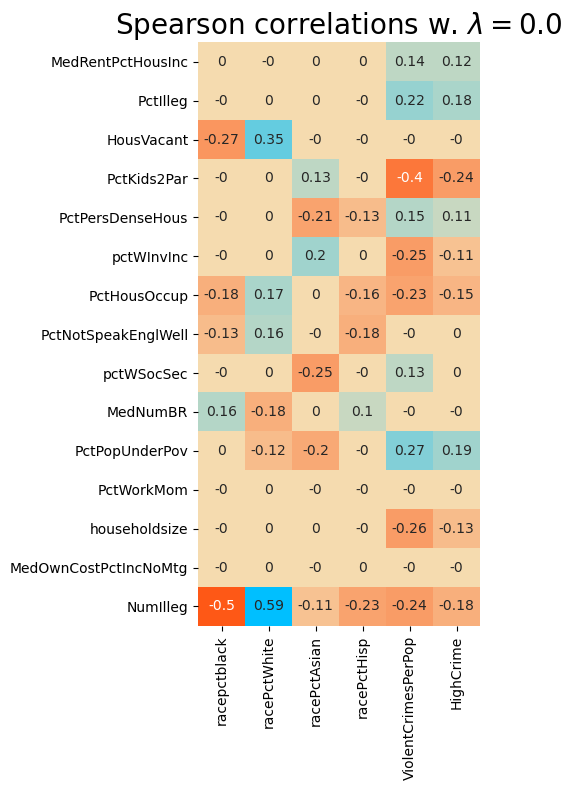

In [83]:
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(speaman_corr[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Spearson correlations w. $\lambda=0.0$", fontsize = 20)
plt.tight_layout()
plt.savefig("Plots/scorr_debias_data_important_features.png")
plt.show()

# Lambda loop correlations
Looking at the correlation between the protected features and debiased data, with different lambdas.

Purpose is to showcase the effect of lambda and how at lambda 0, there should be no pearsons correlations

In [84]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [85]:
lambda_values = np.linspace(1,0,10)

In [86]:
data_sets = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    db, _ = scaler(X, X)
    data_sets[f"{l_value:.2f}"] = db

100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


In [87]:
lambda_res = data_full[protected_cols + y_cols]

In [88]:
lambda_res = data_full[protected_cols + y_cols]
com_col = "NumIlleg"
lambda_cols = []
for col in data_sets.keys():
    tmp_df = pd.DataFrame(data_sets[col], columns=[col for col in X.columns if col not in protected_cols])
    lambda_res[f"l{col}_{com_col}"] = tmp_df[com_col]
    lambda_cols.append(f"l{col}_{com_col}")


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


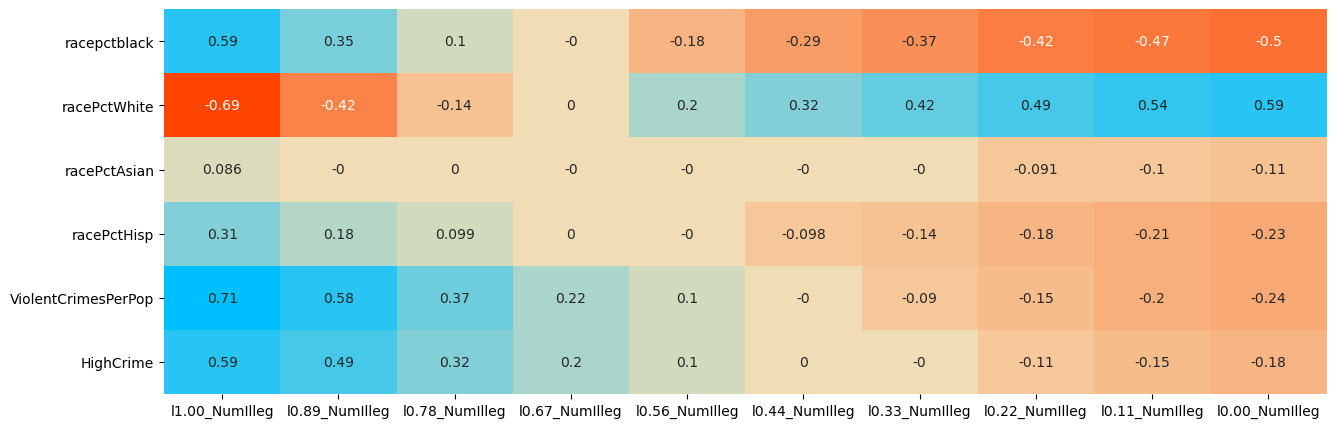

In [89]:
# Spearman corr matrix
speaman_corr = get_significant_correlations(lambda_res, cluster=False, method="spearman")
fig, ax = plt.subplots(1, figsize=(15,5))
sns.heatmap(speaman_corr[protected_cols + y_cols].T[lambda_cols], center=0, annot=True, cmap=cmap, cbar=False)
plt.show()

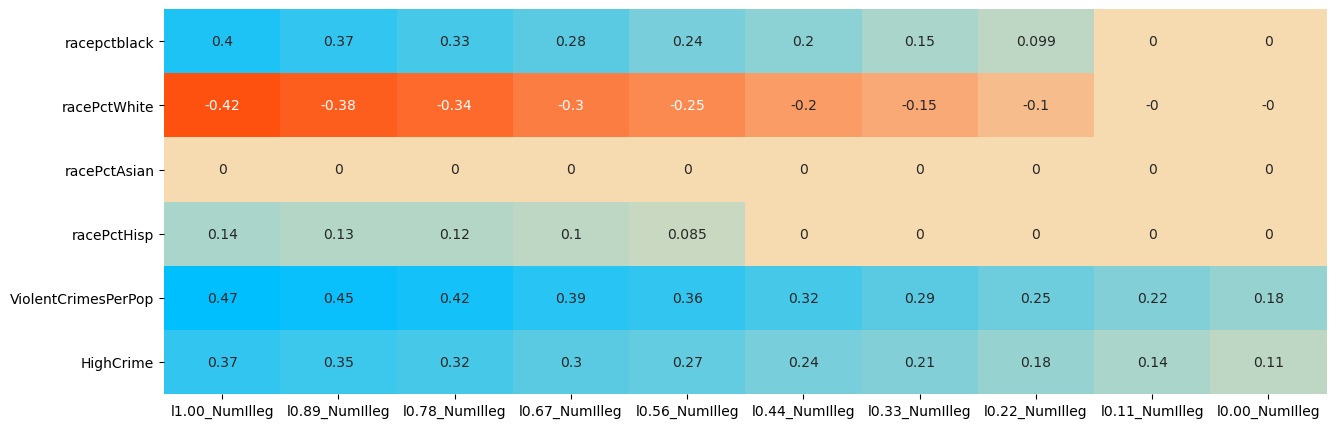

In [90]:
# Pearson corr matrix
pearson_corr = get_significant_correlations(lambda_res, cluster=False, method="pearson")
fig, ax = plt.subplots(1, figsize=(15,5))
sns.heatmap(pearson_corr[protected_cols + y_cols].T[lambda_cols], center=0, annot=True, cmap=cmap, cbar=False)
plt.show()

## Comparing racepct black with all debiased features, w. different lambda

In [91]:
protected_col = "racepctblack"
protected_small_df = data_full[[protected_col]]
pearson_df = pd.DataFrame()
spearman_df = pd.DataFrame()
lambda_cols = []
for col in tqdm(data_sets.keys()):
    tmp_df = pd.DataFrame(data_sets[col], columns=[col for col in X.columns if col not in protected_cols])
    tmp_df = tmp_df.merge(protected_small_df, left_index=True, right_index=True)
    spearman_corr = get_significant_correlations(tmp_df, cluster=False, method="spearman")
    spearman_df[f"l{col}_{protected_col}"] = spearman_corr[[protected_col]]
    pearson_corr = get_significant_correlations(tmp_df, cluster=False, method="pearson")
    pearson_df[f"l{col}_{protected_col}"] = pearson_corr[[protected_col]]

100%|██████████| 10/10 [01:33<00:00,  9.33s/it]


### Pearsons correlations between racepctblack and the debiased data with different lambda

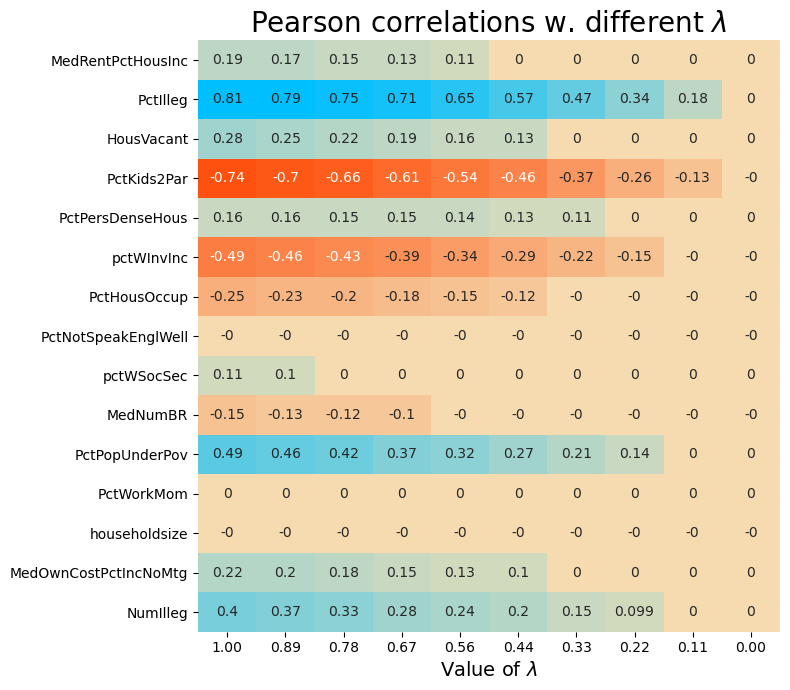

In [92]:
# All columns
x_axis = []
for i in list(pearson_df.columns):
    x_axis.append(i[1:5])

fig, ax = plt.subplots(1, figsize=(8,7))
sns.heatmap(pearson_df.loc[most_important_featureas], xticklabels=x_axis, center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Pearson correlations w. different $\lambda$", fontsize = 20)

plt.xlabel("Value of $\lambda$", fontsize = 14)
plt.tight_layout()
plt.savefig("Plots/pcorr_debias_lambdas_important_features.png")
plt.show()

### Spearman correlations between racepctblack and the debiased data with different lambda

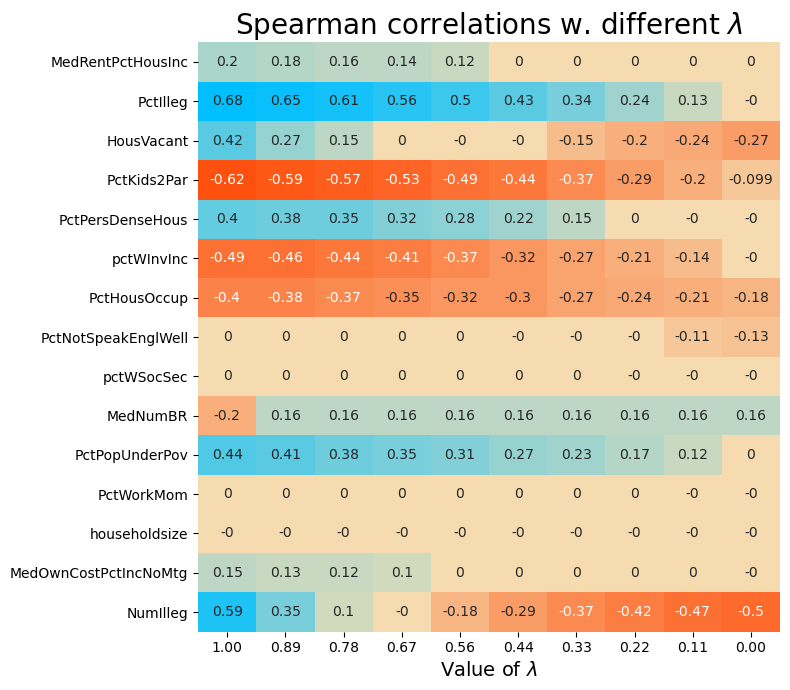

In [93]:
# Most important features
fig, ax = plt.subplots(1, figsize=(8,7))
sns.heatmap(spearman_df.loc[most_important_featureas], xticklabels=x_axis, center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Spearman correlations w. different $\lambda$", fontsize = 20)
plt.xlabel("Value of $\lambda$", fontsize = 14)
plt.tight_layout()
plt.savefig("Plots/scorr_debias_lambdas_important_features.png")
plt.show()

# Using PCA to get most similar neighbourhoods in 2D

In [94]:
from numpy.random import choice
from scipy.spatial import distance

In [95]:
Number_of_pca_dimensions = 2

explained variance ratio (first two components): [0.27389422 0.1834014 ]


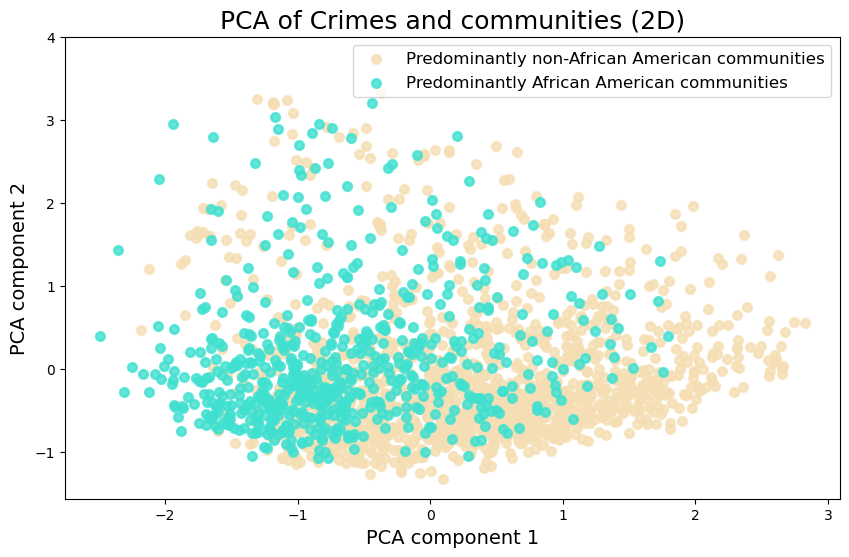

In [96]:
from sklearn.decomposition import PCA

X = data
y = data_full.IsBlack
target_names = ["Predominantly non-African American communities", "Predominantly African American communities"]

pca = PCA(n_components=Number_of_pca_dimensions)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure(figsize = (10,6))
colors = ["wheat", "turquoise"]
lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )

plt.ylim(top = 4)
plt.xlabel("PCA component 1", fontsize = 14)
plt.ylabel("PCA component 2", fontsize = 14)

plt.legend(loc="best", shadow=False, scatterpoints=1, fontsize = 12)
plt.title("PCA of Crimes and communities (2D)", fontsize = 18)

plt.savefig("Plots/PCA_2D.png")
plt.show()

In [97]:
black_pca = []

for i in range(len(X_r[y == 1, 0])):
    point = (X_r[y == 1, 0][i], X_r[y == 1, 1][i])
    black_pca.append(point)
    
white_pca = []

for i in range(len(X_r[y == 0, 0])):
    point = (X_r[y == 0, 0][i], X_r[y == 0, 1][i])
    white_pca.append(point)

#### Analysis

In [98]:
# Pick 10 random white neighbourhoods between -1 and 1 on both axes (most points in these regions)
N_clusters = 10
np.random.seed(43)

white_pca_subset = np.asarray(white_pca)[((np.asarray(white_pca)[:,0] < 1) & (np.asarray(white_pca)[:,0] > -1))]
random_choice = choice(np.arange(0,len(white_pca_subset),1), size = 10)
white_pca_subset_10 = white_pca_subset[random_choice]

In [99]:
# Find 5 nearest white neighbourhoods and 1 nearest black neighbourhood
num_neighbours_N = 5

A = white_pca_subset_10
B = white_pca
C = black_pca

min_dist_B = []
min_B_list = []
min_B_list_index = []

min_dist_C = []
min_C_list = []
min_C_list_index = []

for a in A:
    dist = []
    for b in B:
        dist.append(distance.euclidean(a,b))
    
    dist_b = np.sort(dist)[:num_neighbours_N]
    min_dist_B.append(dist_b)
    
    min_B_index = np.argsort(dist)[:num_neighbours_N]
    min_B = np.asarray(B)[min_B_index]
    
    min_B_list.append(min_B)
    min_B_list_index.append(min_B_index)
    
    dist_c = []
    for c in C:
        dist_c.append(distance.euclidean(a,c))
    min_dist_C.append(min(dist_c))
    min_C_list.append(C[np.argmin(dist_c)])
    min_C_list_index.append(np.argmin(dist_c))

In [100]:
C_x = []
C_y = []
for point in min_C_list:
    C_x.append(point[0])
    C_y.append(point[1])

In [101]:
colours = ['tab:red',
 'tab:blue',
 'tab:green',
 'tab:orange',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:cyan',
 'tab:gray',
 'tab:olive']

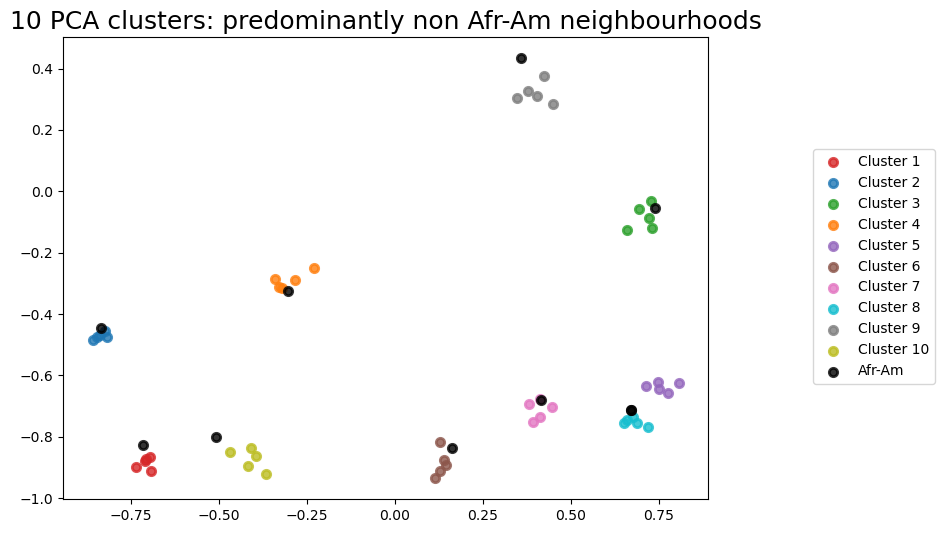

In [102]:
fig, ax = plt.subplots(ncols=1, figsize = (10,6))

lw = 2

for i in range(len(min_B_list)):
    ax.scatter(min_B_list[i][:,0], min_B_list[i][:,1], color=colours[i], alpha=0.8, lw=lw, label=f"Cluster {i+1}")

ax.scatter(C_x, C_y, color="black", alpha=0.8, lw=lw, label=f"Afr-Am")

fig.legend(loc=7, shadow=False, scatterpoints=1)
ax.set_title("10 PCA clusters: predominantly non Afr-Am neighbourhoods", fontsize = 18)
fig.subplots_adjust(right=0.77)  
plt.savefig("Plots/PCA_clusters.png")
plt.show()

Get crime rates from similar white neighbourhoods

In [103]:
# Checking the similarity in terms of crime rate within each cluster 
#pcas = []

crime_rates_pca_neighbourhood_clusters = []
for k in np.arange(0,N_clusters,1):
    current_index = k
    current_cluster = min_B_list[current_index]
    current_indices = min_B_list_index[current_index]

    df_white = data[data_full.IsBlack == 0]

    current_neighbourhood = []
    for i in current_indices:
        current_white = df_white.iloc[[i]]
        current_neighbourhood.append(current_white)

    #Let's double check to be sure that these are the actual pairs which is supposed to be similar: 
    #neighbourhood_pca = []
    #for i in range(len(current_neighbourhood)):
        #white_pca_current = pca.transform(current_neighbourhood[i])
        #neighbourhood_pca.append(white_pca_current)
    #pcas.append(neighbourhood_pca)
    # Now let's look at the crime rates

    df_white_y = data_y[data_full.IsBlack == 0]

    neighbourhood_y = []
    for i in current_indices: 
        current_white_y = df_white_y.iloc[[i]]
        neighbourhood_y.append(current_white_y.ViolentCrimesPerPop.values)
    
    crime_rates_pca_neighbourhood_clusters.append(neighbourhood_y)

In [104]:
crime_rates_pca_neighbourhood_clusters_stds = np.std(crime_rates_pca_neighbourhood_clusters, axis = 1)
np.mean(crime_rates_pca_neighbourhood_clusters_stds)

0.07550947898984253

In [105]:
np.mean(crime_rates_pca_neighbourhood_clusters)

0.1264

In [106]:
crime_rates_pca_black_clusters = []

for k in np.arange(0,N_clusters,1):
    
    current_index = k

    df_black = data[data_full.IsBlack == 1]
    current_black = df_black.iloc[[min_C_list_index[current_index]]]

    # Now let's look at the crime rates
    df_black_y = data_y[data_full.IsBlack == 1]
    current_black_y = df_black_y.iloc[[min_C_list_index[current_index]]]
    crime_rates_pca_black_clusters.append(current_black_y.ViolentCrimesPerPop.values)
    
print(f"Mean black crime rate: {np.mean(crime_rates_pca_black_clusters)}")

Mean black crime rate: 0.21800000000000003


In [107]:
crime_rates_pca_neighbourhood_clusters_stds

array([[0.12955308],
       [0.171744  ],
       [0.05388877],
       [0.06584831],
       [0.0497996 ],
       [0.04690416],
       [0.03224903],
       [0.05059644],
       [0.10099505],
       [0.05351635]])

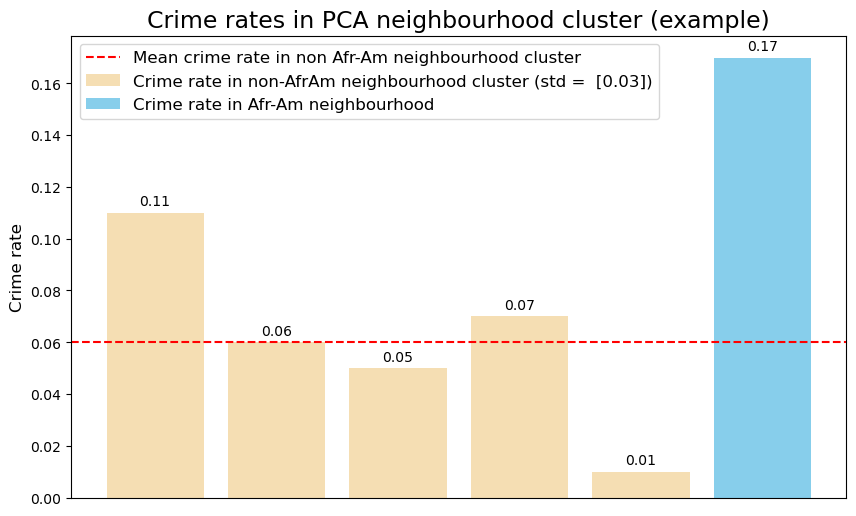

In [108]:
# Plot example of neighbourhood cluster
k = 6

std_neig = crime_rates_pca_neighbourhood_clusters_stds[k]
mean_neig = np.mean((np.asarray(crime_rates_pca_neighbourhood_clusters[k]).ravel()))

fig, ax = plt.subplots(1, 1, figsize = (10,6))

plt.title('Crime rates in PCA neighbourhood cluster (example)', fontsize = 17)

rect = ax.bar(np.arange(1,6,1), np.asarray(crime_rates_pca_neighbourhood_clusters[k]).ravel(), label=f'Crime rate in non-AfrAm neighbourhood cluster (std =  {np.round(std_neig,2)})', color = 'wheat')
ax.axhline(mean_neig, color = 'red', linestyle = '--', label = "Mean crime rate in non Afr-Am neighbourhood cluster")

rect2 = ax.bar(6, crime_rates_pca_black_clusters[k], label=f'Crime rate in Afr-Am neighbourhood', color = 'skyblue')

ax.set_xticks([])

autolabel(rect, ax)
autolabel(rect2, ax)

ax.set_ylabel("Crime rate", fontsize = 12)
ax.legend(fontsize = 12)

plt.savefig("Plots/Neighbourhood_cluster_crime.png")
plt.show()